In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from skimpy import skim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pdb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
np.random.seed(42)
# import pandas_profiling

In [3]:
# subdirs = os.listdir('/Users/awxlong/Desktop/my-studies/temp_data/CRC/TCGA-CRC/gdc_download_20240629_132916.799980/')
cohort_name = 'COAD'
task_name = 'g0_arrest'
# Parent directory containing subdirectories with XML files
parent_directory = '/Users/awxlong/Desktop/my-studies/temp_data/CRC/TCGA-CRC/gdc_download_20240629_132916.799980/'
root_dir = '/Users/awxlong/Desktop/my-studies/hpc_exps/Data/'

df = pd.read_csv(f'{root_dir}{cohort_name}_WSI_clinical_features.csv')


In [4]:
print(df.shape)
df.head()

(448, 26)


,PatientID,Gender,Height,Weight,Age At Initial Pathologic Diagnosis,Race,Other Dx,Pathologic Stage,Pathologic T,Pathologic N,...,Person Neoplasm Cancer Status,Circumferential Resection Margin,Venous Invasion,Lymphatic Invasion,Perineural Invasion Present,History Of Colon Polyps,Synchronous Colon Cancer Present,Colon Polyps Present,Radiation Therapy,Primary Therapy Outcome Success
0,TCGA-CA-5797,MALE,NaN,NaN,56,ASIAN,No,Stage IIA,T3,N0,...,TUMOR FREE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-AA-3543,MALE,NaN,NaN,84,NaN,Yes,Stage I,T2,N0,...,WITH TUMOR,NaN,NO,NO,NaN,YES,NO,NaN,NaN,NaN
2,TCGA-G4-6627,MALE,176.0,80.0,84,WHITE,No,Stage IIA,T3,N0,...,NaN,6.0,NO,NO,NO,NO,NO,YES,NaN,NaN
3,TCGA-AA-3844,FEMALE,NaN,NaN,78,NaN,Yes,Stage IIIC,T3,N2,...,WITH TUMOR,NaN,YES,YES,NaN,NO,NO,NaN,NaN,NaN
4,TCGA-AA-A01P,FEMALE,NaN,NaN,80,NaN,No,Stage III,T3,N1,...,WITH TUMOR,NaN,NaN,YES,NaN,NO,NO,NaN,NaN,NaN


In [5]:
df['Gender'].value_counts()

Gender
MALE      233
FEMALE    215
Name: count, dtype: int64

In [6]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 448    │ │ string      │ 20    │                                                          │
│ │ Number of columns │ 26     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA   ┃ NA %   ┃ mean   ┃ sd     ┃ p0    ┃ p25    ┃ p50  ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ Height                  │  223 │  49.78 │  168.1 │  12.28 │  80.3 │    162 │  170 │   175 │   193 │    ▂▇▃ │  │
│ │ Weight                  │  205 │  45.76 │  81.04 │  20.71 │    34 │  65.45 │   80 │ 93.45 │ 175.3 │  ▂▇▇▁  │  │
│ │ Age At Initial          │    0 │      0 │  67.01 │     13 │    31 │     58 │   68 │    77 │    90 │ ▁▃▅▇▇▅ │  │
│ │ Pathologic Diagnosis    │      │        │        │        │       │        │      │       │       │        │  │
│ │ Lymph Node Examined     │   22 │   4.91 │   22.5 │  12.94 │     0 │     14 │   20 │ 27.75 │   109 │  ▇▇▁   │  │
│ │ Count                   │      │        │        │        │       │        │      │       │       │        │  │
│ │ Number Of Lymphnodes    │   26 │    5.8 │  2.076 │  4.459 │     0 │      0 │    0 │     2 │    50 │   ▇▁   │  │
│ │ Positive By He          │      │        │        │        │       │        │      │       │       │        │  │
│ │ Circumferential         │  379 │   84.6 │  28.79 │  33.65 │     0 │      4 │   20 │    40 │   165 │  ▇▃▁   │  │
│ │ Resection Margin        │      │        │        │        │       │        │      │       │       │        │  │
│ └─────────────────────────┴──────┴────────┴────────┴────────┴───────┴────────┴──────┴───────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                         ┃ NA      ┃ NA %       ┃ words per row           ┃ total words         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ PatientID                           │       0 │          0 │                       1 │                 448 │  │
│ │ Gender                              │       0 │          0 │                       1 │                 448 │  │
│ │ Race                                │     172 │      38.39 │                       1 │                 454 │  │
│ │ Other Dx                            │       0 │          0 │                       1 │                 452 │  │
│ │ Pathologic Stage                    │      11 │       2.46 │                       2 │                 874 │  │
│ │ Pathologic T                        │       0 │          0 │                       1 │                 448 │  │
│ │ Pathologic N                        │       0 │     

In [7]:
# # Numerical features
# num_feats=[col for col in df.columns if df[col].dtypes != 'object']

# # Plot distribution of numerical columns
# fig=plt.figure(figsize=(20,30))
# for i, col in enumerate(num_feats):
#     plt.subplot(len(num_feats),1,1*i+1)
#     sns.distplot(df[col])
    
# fig.tight_layout()
# plt.show()

def icd10_to_description(icd10_codes):
    icd10_descriptions = {
        'C18.0': 'Malignant neoplasm of cecum',
        'C18.2': 'Malignant neoplasm of ascending colon',
        'C18.3': 'Malignant neoplasm of hepatic flexure',
        'C18.4': 'Malignant neoplasm of transverse colon',
        'C18.5': 'Malignant neoplasm of splenic flexure',
        'C18.6': 'Malignant neoplasm of descending colon',
        'C18.7': 'Malignant neoplasm of sigmoid colon',
        'C18.9': 'Malignant neoplasm of colon, unspecified',
        'C19.9': 'Malignant neoplasm of rectosigmoid junction'
    }
    
    descriptions = []
    for code in icd10_codes:
        if code in icd10_descriptions:
            descriptions.append(icd10_descriptions[code])
        else:
            descriptions.append('Unknown ICD-10 code')
    
    return descriptions


In [8]:
print(df.columns)
print(df['Icd 10'].unique())
# print(df['Icd O 3 Site'].unique())

Index(['PatientID', 'Gender', 'Height', 'Weight',
       'Age At Initial Pathologic Diagnosis', 'Race', 'Other Dx',
       'Pathologic Stage', 'Pathologic T', 'Pathologic N', 'Pathologic M',
       'History Of Neoadjuvant Treatment', 'Icd 10',
       'Anatomic Neoplasm Subdivision', 'Lymph Node Examined Count',
       'Number Of Lymphnodes Positive By He', 'Person Neoplasm Cancer Status',
       'Circumferential Resection Margin', 'Venous Invasion',
       'Lymphatic Invasion', 'Perineural Invasion Present',
       'History Of Colon Polyps', 'Synchronous Colon Cancer Present',
       'Colon Polyps Present', 'Radiation Therapy',
       'Primary Therapy Outcome Success'],
      dtype='object')
['C18.9' 'C18.2' 'C18.0' 'C18.7' 'C18.6' 'C19' 'C18.5' 'C18.3' 'C18.4']


<Axes: xlabel='Icd 10'>

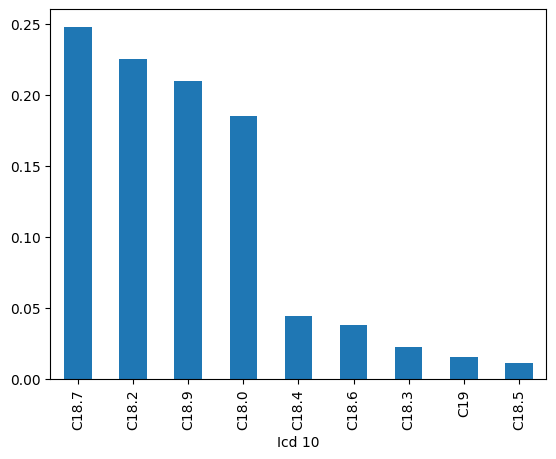

In [9]:
df['Icd 10'].value_counts(normalize=True).plot(kind='bar')


### mode impute missing values

In [10]:
def imputation(split, train_split=df):
   mode_values = train_split.mode().iloc[0]

   imputed_split = split.fillna(mode_values)

   return imputed_split



print("before imputation:", sum(df.isna().sum()))
# print("Number of NaN values per feature: ")
# df_train_na = df_train.apply(mode_imputation, axis = 1)
df = imputation(df)
print("after imputation:", sum(df.isna().sum()))

before imputation: 2653
after imputation: 0


### convert from object to category

In [11]:
categorical_vars = [col for col in df.columns if df[col].dtypes == 'object' and col != 'PatientID']
def cast_category(split, train_cat_vars=categorical_vars):
    split[train_cat_vars] = split[train_cat_vars].astype('category')
    # split = pd.get_dummies(split, columns=train_cat_vars, prefix= train_cat_vars)
    return split
# df_train[categorical_vars] = df_train[categorical_vars].astype('category')
df = cast_category(df)

In [12]:
df.dtypes

PatientID                                object
Gender                                 category
Height                                  float64
Weight                                  float64
Age At Initial Pathologic Diagnosis       int64
Race                                   category
Other Dx                               category
Pathologic Stage                       category
Pathologic T                           category
Pathologic N                           category
Pathologic M                           category
History Of Neoadjuvant Treatment       category
Icd 10                                 category
Anatomic Neoplasm Subdivision          category
Lymph Node Examined Count               float64
Number Of Lymphnodes Positive By He     float64
Person Neoplasm Cancer Status          category
Circumferential Resection Margin        float64
Venous Invasion                        category
Lymphatic Invasion                     category
Perineural Invasion Present            c

### one hot encode categorical variables

In [13]:
def one_hot_encode(split):
  cats = [col for col in split.columns if split[col].dtypes == 'category' and col != 'readmitted']
  split = pd.get_dummies(split, columns=cats, prefix= cats)
  return split

df = one_hot_encode(df)

In [14]:
# df['Circumferential Resection Margin'].unique()


In [15]:
print(df.shape)
df.head()

(448, 87)


,PatientID,Height,Weight,Age At Initial Pathologic Diagnosis,Lymph Node Examined Count,Number Of Lymphnodes Positive By He,Circumferential Resection Margin,Gender_FEMALE,Gender_MALE,Race_AMERICAN INDIAN OR ALASKA NATIVE,...,History Of Colon Polyps_YES,Synchronous Colon Cancer Present_NO,Synchronous Colon Cancer Present_YES,Colon Polyps Present_NO,Colon Polyps Present_YES,Radiation Therapy_NO,Primary Therapy Outcome Success_Complete Remission/Response,Primary Therapy Outcome Success_Partial Remission/Response,Primary Therapy Outcome Success_Progressive Disease,Primary Therapy Outcome Success_Stable Disease
0,TCGA-CA-5797,170.0,57.0,56,12.0,0.0,1.0,False,True,False,...,False,True,False,True,False,True,True,False,False,False
1,TCGA-AA-3543,170.0,57.0,84,25.0,0.0,1.0,False,True,False,...,True,True,False,True,False,True,True,False,False,False
2,TCGA-G4-6627,176.0,80.0,84,16.0,0.0,6.0,False,True,False,...,False,True,False,False,True,True,True,False,False,False
3,TCGA-AA-3844,170.0,57.0,78,18.0,7.0,1.0,True,False,False,...,False,True,False,True,False,True,True,False,False,False
4,TCGA-AA-A01P,170.0,57.0,80,21.0,1.0,1.0,True,False,False,...,False,True,False,True,False,True,True,False,False,False
